# *Hi to all!!!*
# *I have prepared a notebook that works on both COLAB and KAGGLE!!!*

In versions 3 and 4 I show the model I treated on Google COLAB for this notebook https://www.kaggle.com/aikhmelnytskyy/bagging-rainforest

IMPORTANTLY!
This notebook didn't work after the changes to kaggle, but thanks to a discussion by Martin Görner and Allohvk (https://www.kaggle.com/c/rfcx-species-audio-detection/discussion/216408 ), I made the necessary changes in version 4 and now everything works.
Here are the changes:
from

@tf.function

def _preprocess_img(x, training=False, test=False):

to

@tf.function
def _preprocess_img(x, training=False, test=False):

And from

def _specaugment(image):

    image = tfa.image.cutout(image, [HEIGHT, xsize[0]], offset=[HEIGHT//2, xoff[0]])
    image = tfa.image.cutout(image, [HEIGHT, xsize[1]], offset=[HEIGHT//2, xoff[1]])
    image = tfa.image.cutout(image, [ysize[0], WIDTH], offset=[yoff[0], WIDTH//2])
    image = tfa.image.cutout(image, [ysize[1], WIDTH], offset=[yoff[1], WIDTH//2])
    image = tf.squeeze(image, axis=0)
    return image

to

    #image = tfa.image.cutout(image, [HEIGHT, xsize[0]], offset=[HEIGHT//2, xoff[0]])
    #image = tfa.image.cutout(image, [HEIGHT, xsize[1]], offset=[HEIGHT//2, xoff[1]])
    #image = tfa.image.cutout(image, [ysize[0], WIDTH], offset=[yoff[0], WIDTH//2])
    #image = tfa.image.cutout(image, [ysize[1], WIDTH], offset=[yoff[1], WIDTH//2])
    image = tf.squeeze(image, axis=0)
    return image

Version 5 changes as shown in this discussion https://www.kaggle.com/c/rfcx-species-audio-detection/discussion/218930 (special thanks to the author)

I used these notebooks as a basis:
https://www.kaggle.com/mekhdigakhramanian/rfcx-resnet50-tpu
https://www.kaggle.com/khoongweihao/resnet34-more-augmentations-mixup-tta-inference


It is important to work with colab you need kaggle.json (https://www.kaggle.com/docs/api)

I also created a folder called Models on my Google Drive and put the kaggle.json file in it.

In [1]:
import os

COLAB=False
models_path=''

if not os.path.exists('../input/rfcx-species-audio-detection'):# Let's check if we use kaggle notebook
    COLAB=True
    import gc
    from google.colab import drive
    drive.mount('/content/drive')# You must grant COLAB access to your Google Drive
    
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    GCS_DS_PATH = 'gs://kds-5c677f76ce55440722b2a474a5492faa70847c05a8f5d722f5a37feb'# 
    #This is a path to a dataset that changes over time, so you need to constantly update it. To update the path just run the code: 
    #GCS_DS_PATH = KaggleDatasets (). Get_gcs_path ()
    #print (GCS_DS_PATH)
    models_path='/content/drive/MyDrive/Models/'# I created a folder called Models on my Google Drive and put the kaggle.json file in it
else:
    from kaggle_datasets import KaggleDatasets
    GCS_DS_PATH = KaggleDatasets().get_gcs_path('rfcx-species-audio-detection')
    print (GCS_DS_PATH)

gs://kds-a7dd8b09d52950714bee1818d843af117accc125d4d289d9afcebfab


In [2]:
if COLAB:# Prepare the kaggle.json file for use 
    from google.colab import files
    if not os.path.exists('/.kaggle/kaggle.json'):
        !mkdir ~/.kaggle
        if not os.path.exists('/content/drive/My Drive/Models/kaggle.json'):
            files.upload()
            !cp kaggle.json ~/.kaggle/
        else:
            !cp '/content/drive/My Drive/Models/kaggle.json' ~/.kaggle/  
        !chmod 600 ~/.kaggle/kaggle.json

In [3]:
if COLAB:# force TF to 2.2
    !pip install -q tensorflow~=2.2.0 tensorflow_gcs_config~=2.2.0
    import tensorflow as tf
    import requests
    import os
    resp = requests.post("http://{}:8475/requestversion/{}".format(os.environ["COLAB_TPU_ADDR"].split(":")[0], tf.__version__))
    if resp.status_code != 200:
      print("Failed to switch the TPU to TF {}".format(version))

In [4]:
if COLAB:    #%tensorflow_version 2.x
    import tensorflow as tf
    print("Tensorflow version " + tf.__version__)

    try:
      tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
      print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
      raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    #tpu_strategy = tf.distribute.TPUStrategy(tpu) 

In [5]:
!pip install -q tensorflow_io
import tensorflow_io as tfio
import tensorflow as tf
import gc
!pip install image-classifiers
!pip install tensorflow_addons==0.10.0
#0.11.2
import tensorflow_addons as tfa
#import tfa as tfa
import numpy as np
from pathlib import Path
import io
import matplotlib.pyplot as plt
!pip install soundfile
import soundfile as sf
import librosa
#!pip install kaggle_datasets

#from kaggle_datasets import KaggleDatasets
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from IPython.display import Audio

from classification_models.keras import Classifiers
tf.__version__

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 50 kB 1.5 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.0 MB 2.9 MB/s 
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.12.0
    Uninstalling tensorflow-addons-0.12.0:
      Successfully uninstalled tensorflow-addons-0.12.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


'2.4.0'

In [6]:

from classification_models.keras import Classifiers

In [7]:
#SEED = 42
import random 
SEED = random.randint(0, 10000)# !!!!
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(SEED)

In [8]:
# from https://github.com/qubvel/classification_models
ResNet34, preprocess_input = Classifiers.get('resnet34')

In [9]:
cfg = {
    'parse_params': {
        'cut_time': 10,
    },
    'data_params': {
        'sample_time': 6, # assert 60 % sample_time == 0
        'spec_fmax': 24000.0,
        'spec_fmin': 40.0,
        'spec_mel': 300, 
        'mel_power': 2,
        'img_shape': (300, 670)
    },
    'model_params': {
        'batchsize_per_tpu': 8,
        'iteration_per_epoch': 128,
        'epoch': 25,#  1 epoch just for example
        'arch': ResNet34,
        'arch_preprocess': preprocess_input,
        'freeze_to': 0,  # Freeze to backbone.layers[:freeze_to]. If None, all layers in the backbone will be freezed.
        'loss': {
            'fn': tfa.losses.SigmoidFocalCrossEntropy,
            'params': {},
        },
        'optim': {
            'fn': tfa.optimizers.RectifiedAdam,
            'params': {'lr': 2e-3, 'total_steps': 18*64, 'warmup_proportion': 0.3, 'min_lr': 1e-6},
        },
        'mixup': True # False
    }
}

In [10]:
# detect and init the TPU
if not COLAB:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print("All devices: ", tf.config.list_logical_devices('TPU'))
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU')]


In [11]:

AUTOTUNE = tf.data.experimental.AUTOTUNE


TRAIN_TFREC = GCS_DS_PATH + "/tfrecords/train"
TEST_TFREC = GCS_DS_PATH + "/tfrecords/test"

In [12]:
CUT = cfg['parse_params']['cut_time']
SR = 48000     # all wave's sample rate may be 48k

TIME = cfg['data_params']['sample_time']

FMAX = cfg['data_params']['spec_fmax']
FMIN = cfg['data_params']['spec_fmin']
N_MEL = cfg['data_params']['spec_mel']

HEIGHT, WIDTH = cfg['data_params']['img_shape']

CLASS_N = 24

# Explore the tfrecords, Create dataset

In [13]:
raw_dataset = tf.data.TFRecordDataset([TRAIN_TFREC + '/00-148.tfrec'])
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

## parse tfrecords

In [14]:
feature_description = {
    'recording_id': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'audio_wav': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'label_info': tf.io.FixedLenFeature([], tf.string, default_value=''),
}
parse_dtype = {
    'audio_wav': tf.float32,
    'recording_id': tf.string,
    'species_id': tf.int32,
    'songtype_id': tf.int32,
    't_min': tf.float32,
    'f_min': tf.float32,
    't_max': tf.float32,
    'f_max':tf.float32,
    'is_tp': tf.int32
}

@tf.function
def _parse_function(example_proto):
    sample = tf.io.parse_single_example(example_proto, feature_description)
    wav, _ = tf.audio.decode_wav(sample['audio_wav'], desired_channels=1) # mono
    label_info = tf.strings.split(sample['label_info'], sep='"')[1]
    labels = tf.strings.split(label_info, sep=';')
    
    @tf.function
    def _cut_audio(label):
        items = tf.strings.split(label, sep=',')
        spid = tf.squeeze(tf.strings.to_number(items[0], tf.int32))
        soid = tf.squeeze(tf.strings.to_number(items[1], tf.int32))
        tmin = tf.squeeze(tf.strings.to_number(items[2]))
        fmin = tf.squeeze(tf.strings.to_number(items[3]))
        tmax = tf.squeeze(tf.strings.to_number(items[4]))
        fmax = tf.squeeze(tf.strings.to_number(items[5]))
        tp = tf.squeeze(tf.strings.to_number(items[6], tf.int32))

        tmax_s = tmax * tf.cast(SR, tf.float32)
        tmin_s = tmin * tf.cast(SR, tf.float32)
        cut_s = tf.cast(CUT * SR, tf.float32)
        all_s = tf.cast(60 * SR, tf.float32)
        tsize_s = tmax_s - tmin_s
        cut_min = tf.cast(
            tf.maximum(0.0, 
                tf.minimum(tmin_s - (cut_s - tsize_s) / 2,
                           tf.minimum(tmax_s + (cut_s - tsize_s) / 2, all_s) - cut_s)
            ), tf.int32
        )
        cut_max = cut_min + CUT * SR
        
        _sample = {
            'audio_wav': tf.reshape(wav[cut_min:cut_max], [CUT*SR]),
            'recording_id': sample['recording_id'],
            'species_id': spid,
            'songtype_id': soid,
            't_min': tmin - tf.cast(cut_min, tf.float32)/tf.cast(SR, tf.float32),
            'f_min': fmin,
            't_max': tmax - tf.cast(cut_min, tf.float32)/tf.cast(SR, tf.float32),
            'f_max': fmax,
            'is_tp': tp
        }
        return _sample
    
    samples = tf.map_fn(_cut_audio, labels, dtype=parse_dtype)
    return samples

parsed_dataset = raw_dataset.map(_parse_function).unbatch()

In [15]:
@tf.function
def _cut_wav(x):
    # random cut in training
    cut_min = tf.random.uniform([], maxval=(CUT-TIME)*SR, dtype=tf.int32)
    cut_max = cut_min + TIME * SR
    cutwave = tf.reshape(x['audio_wav'][cut_min:cut_max], [TIME*SR])
    y = {}
    y.update(x)
    y['audio_wav'] = cutwave
    y['t_min'] = tf.maximum(0.0, x['t_min'] - tf.cast(cut_min, tf.float32) / SR)
    y['t_max'] = tf.maximum(0.0, x['t_max'] - tf.cast(cut_min, tf.float32) / SR)
    return y
    
@tf.function
def _cut_wav_val(x):
    # center crop in validation
    cut_min = (CUT-TIME)*SR // 2
    cut_max = cut_min + TIME * SR
    cutwave = tf.reshape(x['audio_wav'][cut_min:cut_max], [TIME*SR])
    y = {}
    y.update(x)
    y['audio_wav'] = cutwave
    y['t_min'] = tf.maximum(0.0, x['t_min'] - tf.cast(cut_min, tf.float32) / SR)
    y['t_max'] = tf.maximum(0.0, x['t_max'] - tf.cast(cut_min, tf.float32) / SR)
    return y

In [16]:
@tf.function
def _filtTP(x):
    return x['is_tp'] == 1

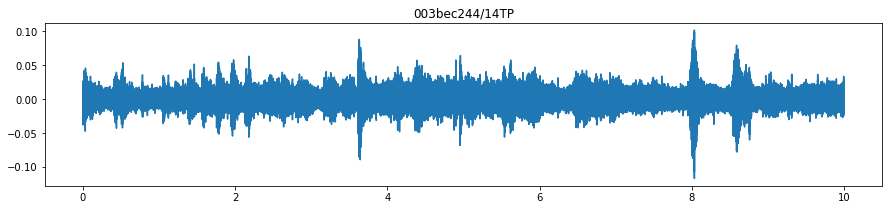

In [17]:
def show_wav(sample, ax):
    wav = sample["audio_wav"].numpy()
    rate = SR
    ax.plot(np.arange(len(wav)) / rate, wav)
    ax.set_title(
        sample["recording_id"].numpy().decode()
        + ("/%d" % sample["species_id"])
        + ("TP" if sample["is_tp"] else "FP"))

    return Audio((wav * 2**15).astype(np.int16), rate=rate)

fig, ax = plt.subplots(figsize=(15, 3))
show_wav(next(iter(parsed_dataset)), ax)

## create mel-spectrogram

In [18]:
@tf.function
def _wav_to_spec(x):
    mel_power = cfg['data_params']['mel_power']
    
    stfts = tf.signal.stft(x["audio_wav"], frame_length=2048, frame_step=512, fft_length=2048)
    spectrograms = tf.abs(stfts) ** mel_power

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = FMIN, FMAX, N_MEL
    
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, SR, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    y = {
        'audio_spec': tf.transpose(log_mel_spectrograms), # (num_mel_bins, frames)
    }
    y.update(x)
    return y

spec_dataset = parsed_dataset.filter(_filtTP).map(_cut_wav).map(_wav_to_spec)

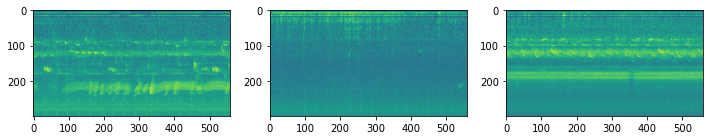

In [19]:
plt.figure(figsize=(12,5))
for i, s in enumerate(spec_dataset.take(3)):
    plt.subplot(1,3,i+1)
    plt.imshow(s['audio_spec'])
plt.show()

In [20]:
import librosa.display
import matplotlib.patches as patches

def show_spectrogram(sample, ax, showlabel=False):
    S_dB = sample["audio_spec"].numpy()
    img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=SR,
                             fmax=FMAX, fmin=FMIN, ax=ax, cmap='magma')
    ax.set(title=f'Mel-frequency spectrogram of {sample["recording_id"].numpy().decode()}')
    sid, fmin, fmax, tmin, tmax, istp = (
            sample["species_id"], sample["f_min"], sample["f_max"], sample["t_min"], sample["t_max"], sample["is_tp"])
    ec = '#00ff00' if istp == 1 else '#0000ff'
    ax.add_patch(
        patches.Rectangle(xy=(tmin, fmin), width=tmax-tmin, height=fmax-fmin, ec=ec, fill=False)
    )

    if showlabel:
        ax.text(tmin, fmax, 
        f"{sid.numpy().item()} {'tp' if istp == 1 else 'fp'}",
        horizontalalignment='left', verticalalignment='bottom', color=ec, fontsize=16)

/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


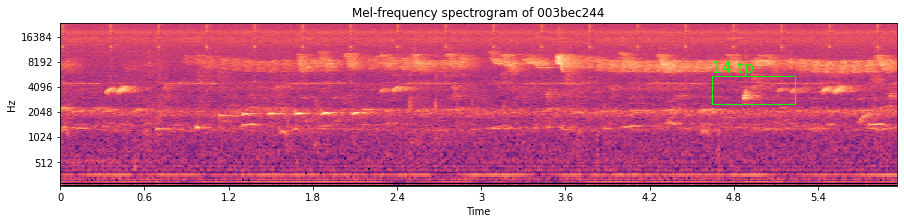

In [21]:
fig, ax = plt.subplots(figsize=(15,3))
show_spectrogram(next(iter(spec_dataset)), ax, showlabel=True)

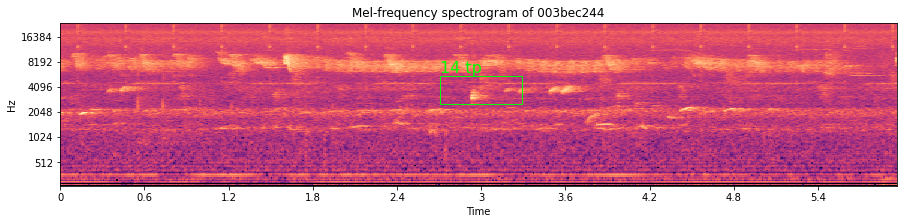

In [22]:
# in validation, annotations will come to the center
fig, ax = plt.subplots(figsize=(15,3))
show_spectrogram(next(iter(parsed_dataset.filter(_filtTP).map(_cut_wav_val).map(_wav_to_spec))), ax, showlabel=True)

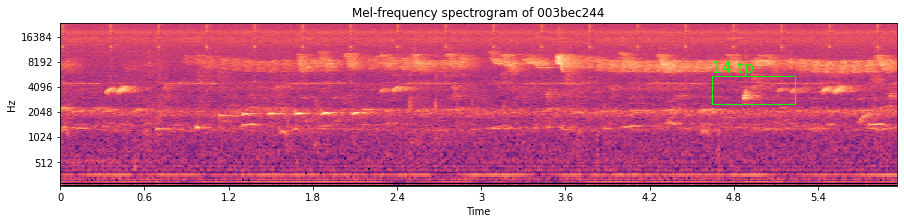

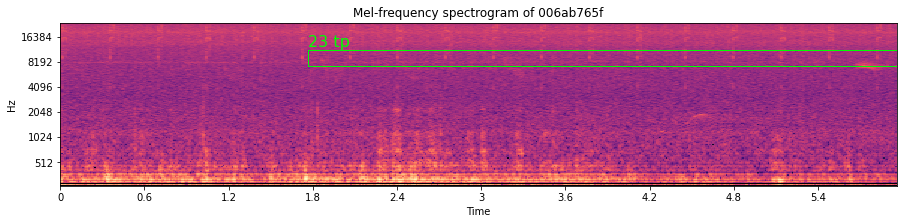

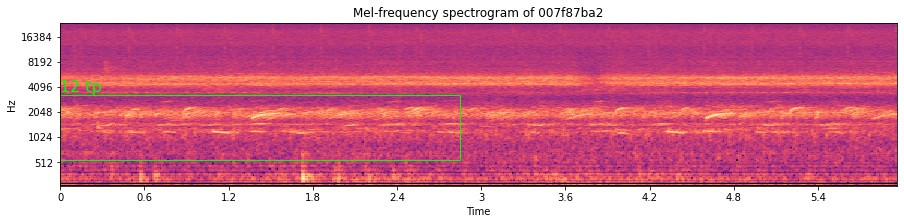

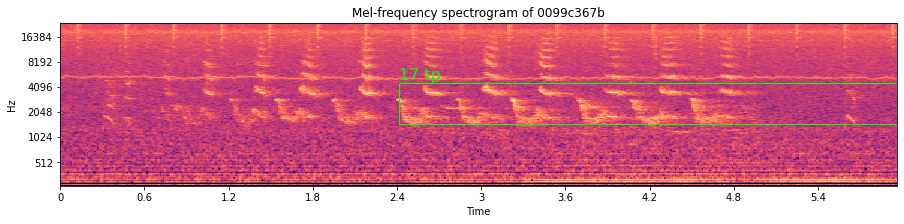

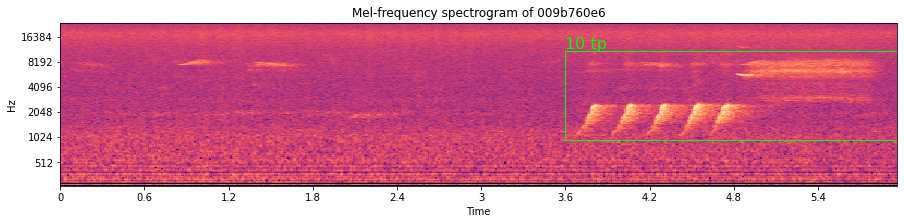

In [23]:
for sample in spec_dataset.take(5):
    fig, ax = plt.subplots(figsize=(15,3))
    show_spectrogram(sample, ax, showlabel=True)

## create labels

In [24]:
@tf.function
def _create_annot(x):
    targ = tf.one_hot(x["species_id"], CLASS_N, on_value=x["is_tp"], off_value=0)
    
    return {
        'input': x["audio_spec"],
        'target': tf.cast(targ, tf.float32)
    }

annot_dataset = spec_dataset.map(_create_annot)

## proprocessing and data augmentation

In training, I use

* gaussian noise
* random brightness
* specaugment

In [25]:
#@tf.function
def _preprocess_img(x, training=False, test=False):
    image = tf.expand_dims(x, axis=-1)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.image.per_image_standardization(image)
    
    @tf.function
    def _specaugment(image):
        ERASE_TIME = 50
        ERASE_MEL = 16
        image = tf.squeeze(image, axis=2)
        image = tfio.experimental.audio.time_mask(image, param=ERASE_TIME)
        image = tfio.experimental.audio.freq_mask(image, param=ERASE_MEL)
        image = tf.expand_dims(image, axis=2)
        return image
    
    if training:
        # gaussian
        gau = tf.keras.layers.GaussianNoise(0.3)
        image = tf.cond(tf.random.uniform([]) < 0.5, lambda: gau(image, training=True), lambda: image)
        # brightness
        image = tf.image.random_brightness(image, 0.2)
        # random left right flip (NEW)
        image = tf.image.random_flip_left_right(image)
        # specaugment
        image = tf.cond(tf.random.uniform([]) < 0.5, lambda: _specaugment(image), lambda: image)
        
    if test:
        # specaugment
        image = tf.cond(tf.random.uniform([]) < 0.5, lambda: _specaugment(image), lambda: image)
        
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image)) * 255.0 # rescale to [0, 255]
    image = tf.image.grayscale_to_rgb(image)
    image = cfg['model_params']['arch_preprocess'](image)

    return image

@tf.function
def _preprocess(x):
    image = _preprocess_img(x['input'], training=True, test=False)
    return (image, x["target"])

@tf.function
def _preprocess_val(x):
    image = _preprocess_img(x['input'], training=False, test=False)
    return (image, x["target"])

@tf.function
def _preprocess_test(x):
    image = _preprocess_img(x['audio_spec'], training=False, test=True)
    return (image, x["recording_id"])

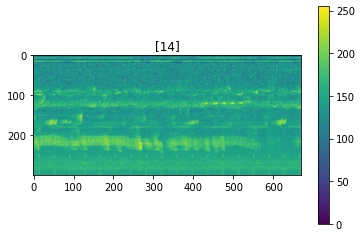

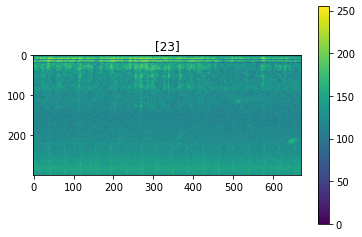

In [26]:
for inp, targ in annot_dataset.map(_preprocess).take(2):
    plt.imshow(inp.numpy()[:,:,0])
    t = targ.numpy()
    if t.sum() == 0:
        plt.title(f'FP')
    else:
        plt.title(f'{t.nonzero()[0]}')
    plt.colorbar()
    plt.show()

# Model

In [27]:
from tensorflow.keras.layers import *
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras.optimizers import Adam
def create_model():
    #with strategy.scope():
    #backbone = cfg['model_params']['arch'](include_top=False, weights='imagenet')
    
    def Classifier(shape_):

        backbone = cfg['model_params']['arch']((shape_), include_top=False, weights='imagenet')
    
    
        
        def cbr(x, out_layer, kernel, stride, dilation):
            x = Conv2D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            return x

        def wave_block(x, filters, kernel_size, n):
            dilation_rates = [2**i for i in range(n)]
            x = Conv2D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = x
            for dilation_rate in dilation_rates:
                tanh_out = Conv2D(filters = filters,
                                  kernel_size = kernel_size,
                                  padding = 'same', 
                                  activation = 'tanh', 
                                  dilation_rate = dilation_rate)(x)
                sigm_out = Conv2D(filters = filters,
                                  kernel_size = kernel_size,
                                  padding = 'same',
                                  activation = 'sigmoid', 
                                  dilation_rate = dilation_rate)(x)
                x = Multiply()([tanh_out, sigm_out])
                x = Conv2D(filters = filters,
                           kernel_size = 1,
                           padding = 'same')(x)
                res_x = Add()([res_x, x])
            return res_x

        
        #out1
        def wavenet(layer):
          
          x = cbr(layer, 192, 7, 1, 1)
          x = BatchNormalization()(x)
          x = wave_block(x, 192, 3, 1)
          x = cbr(x, 96, 7, 1, 1)
          x = BatchNormalization()(x)
          x = wave_block(x, 96, 3, 1)
          x = cbr(x, 48, 5, 1, 1)
          x = BatchNormalization()(x)
          x = wave_block(x, 48, 3, 1)  
          return x

        def wavenet1(layer):
          
          x = cbr(layer, 4, 7, 1, 1)
          x = BatchNormalization()(x)
          x = wave_block(x, 3, 3, 1)
          x = cbr(x, 3, 7, 1, 1)
          x = BatchNormalization()(x)
          x = wave_block(x, 16, 3, 1)
          x = cbr(x, 3, 5, 1, 1)
          return x
        #x = BatchNormalization()(x)
        
        x0 = backbone#model
        print('1')
        #backbone.summary()
        x1 = tf.keras.layers.GlobalAveragePooling2D()(x0.layers[-1].output)  #-3,-7,-9,-15  for EF5    
        #x2 = tf.keras.layers.GlobalAveragePooling2D()(x0.layers[-3].output) # 803,799,797,791 for EF7
        x3 = tf.keras.layers.GlobalAveragePooling2D()(x0.layers[-7].output)
        #x4 = tf.keras.layers.GlobalAveragePooling2D()(x0.layers[-12].output)
        x5 = tf.keras.layers.GlobalAveragePooling2D()(x0.layers[-18].output)
        print('2')
        x1=wavenet(x0.layers[-1].output)
        x3=wavenet(x0.layers[-7].output)
        x5=wavenet(x0.layers[-18].output)

        x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
        x3 = tf.keras.layers.GlobalAveragePooling2D()(x3)
        x5 = tf.keras.layers.GlobalAveragePooling2D()(x5)
       
        
        
        print('4')
        #x =  tf.concat([x1,x2,x3,x4,x5],axis = 1)
       
        x =  tf.concat([x1,x3,x5],axis = 1)
      
        x = tf.keras.layers.Dropout(0.7)(x)
        x = tf.keras.layers.Dense(192)(x)
        #x =  tf.keras.layers.BatchNormalization()(x)          
        x = tf.keras.layers.Dropout(0.4)(x)
        #x =  margin([x , label])
        
        output = tf.keras.layers.Softmax(dtype='float32')(x)
        output =tf.keras.layers.Dense(CLASS_N)(x)
        print('5')
        model = tf.keras.models.Model(inputs = x0.input, outputs = output)
        #model.compile(optimizer=optimizer, loss=loss_fn, metrics=[LWLRAP(CLASS_N)])
        

        
        
        return model
    return Classifier([HEIGHT,WIDTH,3])


model = create_model()
model.summary()


85524480/85521592 [==============================] - 1s 0us/step
1
2
4
5
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 300, 670, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 300, 670, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 676, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 150, 335, 64) 9408        zero_padding2d[0][0]             
___________________

In [28]:
@tf.function
def _mixup(inp, targ):
    indice = tf.range(len(inp))
    indice = tf.random.shuffle(indice)
    sinp = tf.gather(inp, indice, axis=0)
    starg = tf.gather(targ, indice, axis=0)
    
    alpha = 0.2
    t = tf.compat.v1.distributions.Beta(alpha, alpha).sample([len(inp)])
    tx = tf.reshape(t, [-1, 1, 1, 1])
    ty = tf.reshape(t, [-1, 1])
    x = inp * tx + sinp * (1-tx)
    y = targ * ty + starg * (1-ty)
#     y = tf.minimum(targ + starg, 1.0) # for multi-label???
    return x, y

In [29]:
tfrecs = sorted(tf.io.gfile.glob(TRAIN_TFREC + '/*.tfrec'))
parsed_trainval = (tf.data.TFRecordDataset(tfrecs, num_parallel_reads=AUTOTUNE)
                    .map(_parse_function, num_parallel_calls=AUTOTUNE).unbatch()
                    .filter(_filtTP).enumerate())

# Stratified 5-Fold

In [30]:
indices = []
spid = []
recid = []

for i, sample in tqdm(parsed_trainval.prefetch(AUTOTUNE)):
    indices.append(i.numpy())
    spid.append(sample['species_id'].numpy())
    recid.append(sample['recording_id'].numpy().decode())

1216it [00:36, 33.18it/s] 


In [31]:
table = pd.DataFrame({'indices': indices, 'species_id': spid, 'recording_id': recid})
table

,indices,species_id,recording_id
0,0,14,003bec244
1,1,12,2026bced7
2,2,21,422de4e4d
3,3,6,60a493ad4
4,4,13,8080b2283
...,...,...,...
1211,1211,3,807efd6bb
1212,1212,20,a6610076b
1213,1213,23,c91cae4aa
1214,1214,3,c91cae4aa


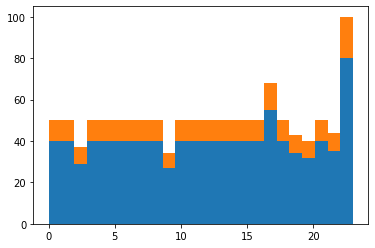

In [32]:
skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
splits = list(skf.split(table.index, table.species_id))

plt.hist([table.loc[splits[0][0], 'species_id'], table.loc[splits[0][1], 'species_id']], bins=CLASS_N,stacked=True)
plt.show()

In [33]:
def create_idx_filter(indice):
    @tf.function
    def _filt(i, x):
        return tf.reduce_any(indice == i)
    return _filt

@tf.function
def _remove_idx(i, x):
    return x

# Other setup

In [34]:
def create_train_dataset(batchsize, train_idx):
    global parsed_trainval
    parsed_train = (parsed_trainval
                    .filter(create_idx_filter(train_idx))
                    .map(_remove_idx))
    
    dataset = (parsed_train.cache()
        .shuffle(len(train_idx))
        .repeat()
        .map(_cut_wav, num_parallel_calls=AUTOTUNE)
        .map(_wav_to_spec, num_parallel_calls=AUTOTUNE)
        .map(_create_annot, num_parallel_calls=AUTOTUNE)
        .map(_preprocess, num_parallel_calls=AUTOTUNE)
        .batch(batchsize))

    if cfg['model_params']['mixup']:
        dataset = (dataset.map(_mixup, num_parallel_calls=AUTOTUNE)
                    .prefetch(AUTOTUNE))
    else:
        dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def create_val_dataset(batchsize, val_idx):
    global parsed_trainval
    parsed_val = (parsed_trainval
                  .filter(create_idx_filter(val_idx))
                  .map(_remove_idx))

    vdataset = (parsed_val
        .map(_cut_wav_val, num_parallel_calls=AUTOTUNE)
        .map(_wav_to_spec, num_parallel_calls=AUTOTUNE)
        .map(_create_annot, num_parallel_calls=AUTOTUNE)
        .map(_preprocess_val, num_parallel_calls=AUTOTUNE)
        .batch(8*tpu_strategy.num_replicas_in_sync)
        .cache())
    return vdataset

# Metrics

In [35]:
# from https://www.kaggle.com/carlthome/l-lrap-metric-for-tf-keras
@tf.function
def _one_sample_positive_class_precisions(example):
    y_true, y_pred = example

    retrieved_classes = tf.argsort(y_pred, direction='DESCENDING')
    class_rankings = tf.argsort(retrieved_classes)
    retrieved_class_true = tf.gather(y_true, retrieved_classes)
    retrieved_cumulative_hits = tf.math.cumsum(tf.cast(retrieved_class_true, tf.float32))

    idx = tf.where(y_true)[:, 0]
    i = tf.boolean_mask(class_rankings, y_true)
    r = tf.gather(retrieved_cumulative_hits, i)
    c = 1 + tf.cast(i, tf.float32)
    precisions = r / c

    dense = tf.scatter_nd(idx[:, None], precisions, [y_pred.shape[0]])
    return dense

class LWLRAP(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='lwlrap'):
        super().__init__(name=name)

        self._precisions = self.add_weight(
            name='per_class_cumulative_precision',
            shape=[num_classes],
            initializer='zeros',
        )

        self._counts = self.add_weight(
            name='per_class_cumulative_count',
            shape=[num_classes],
            initializer='zeros',
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        precisions = tf.map_fn(
            fn=_one_sample_positive_class_precisions,
            elems=(y_true, y_pred),
            dtype=(tf.float32),
        )

        increments = tf.cast(precisions > 0, tf.float32)
        total_increments = tf.reduce_sum(increments, axis=0)
        total_precisions = tf.reduce_sum(precisions, axis=0)

        self._precisions.assign_add(total_precisions)
        self._counts.assign_add(total_increments)        

    def result(self):
        per_class_lwlrap = self._precisions / tf.maximum(self._counts, 1.0)
        per_class_weight = self._counts / tf.reduce_sum(self._counts)
        overall_lwlrap = tf.reduce_sum(per_class_lwlrap * per_class_weight)
        return overall_lwlrap

    def reset_states(self):
        self._precisions.assign(self._precisions * 0)
        self._counts.assign(self._counts * 0)

# Testset and Inference function

In [36]:

def _parse_function_test(example_proto):
    sample = tf.io.parse_single_example(example_proto, feature_description)
    wav, _ = tf.audio.decode_wav(sample['audio_wav'], desired_channels=1) # mono
    
    @tf.function
    def _cut_audio(i):
        _sample = {
            'audio_wav': tf.reshape(wav[i*SR*TIME:(i+1)*SR*TIME], [SR*TIME]),
            'recording_id': sample['recording_id']
        }
        return _sample

    return tf.map_fn(_cut_audio, tf.range(60//TIME), dtype={
        'audio_wav': tf.float32,
        'recording_id': tf.string
    })

def inference(model):
    tdataset = (tf.data.TFRecordDataset(tf.io.gfile.glob(TEST_TFREC + '/*.tfrec'), num_parallel_reads=AUTOTUNE)
        .map(_parse_function_test, num_parallel_calls=AUTOTUNE).unbatch()
        .map(_wav_to_spec, num_parallel_calls=AUTOTUNE)
        .map(_preprocess_test, num_parallel_calls=AUTOTUNE)
        .batch(128*(60//TIME)).prefetch(AUTOTUNE))
    
    rec_ids = []
    probs = []
    for inp, rec_id in tqdm(tdataset):
        with tpu_strategy.scope():
            pred = model.predict_on_batch(tf.reshape(inp, [-1, HEIGHT, WIDTH, 3]))
            prob = tf.sigmoid(pred)
            prob = tf.reduce_max(tf.reshape(prob, [-1, 60//TIME, CLASS_N]), axis=1)

        rec_id_stack = tf.reshape(rec_id, [-1, 60//TIME])
        for rec in rec_id.numpy():
            assert len(np.unique(rec)) == 1
        rec_ids.append(rec_id_stack.numpy()[:,0])
        probs.append(prob.numpy())
        
    crec_ids = np.concatenate(rec_ids)
    cprobs = np.concatenate(probs)
    
    sub = pd.DataFrame({
        'recording_id': list(map(lambda x: x.decode(), crec_ids.tolist())),
        **{f's{i}': cprobs[:,i] for i in range(CLASS_N)}
    })
    sub = sub.sort_values('recording_id')

    return sub

# Now start training!

In [37]:
def plot_history(history, name):
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.title("loss")
    # plt.yscale('log')

    plt.subplot(1,2,2)
    plt.plot(history.history["lwlrap"])
    plt.plot(history.history["val_lwlrap"])
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.title("metric")

    plt.savefig(name)

In [38]:
def train_and_inference(splits, split_id):
    print(split_id)

    batchsize = cfg['model_params']['batchsize_per_tpu'] * tpu_strategy.num_replicas_in_sync
    print("batchsize", batchsize)
    loss_fn = cfg['model_params']['loss']['fn'](from_logits=True, **cfg['model_params']['loss']['params'])

    idx_train_tf = tf.constant(splits[split_id][0])
    idx_val_tf = tf.constant(splits[split_id][1])

    dataset = create_train_dataset(batchsize, idx_train_tf)
    vdataset = create_val_dataset(batchsize, idx_val_tf)
    
    optimizer = cfg['model_params']['optim']['fn'](**cfg['model_params']['optim']['params'])
    
    with tpu_strategy.scope():
        model = create_model()
        model.compile(optimizer=optimizer, loss=loss_fn, metrics=[LWLRAP(CLASS_N)])
    
    if split_id not in (10,10):#!!!!!!!!!!!!! For convenience: If your Colab shuts down for some reason, you can always download your already trained models from Google Drive

        history = model.fit(dataset,
                          steps_per_epoch=cfg['model_params']['iteration_per_epoch'],
                          epochs=cfg['model_params']['epoch'],
                          validation_data=vdataset,
                          callbacks=[
                              tf.keras.callbacks.ReduceLROnPlateau(
                                  'val_lwlrap', patience=10
                              ),  
                              tf.keras.callbacks.ModelCheckpoint(
                                  filepath=models_path+'model_best_%d.h5' % split_id,
                                  save_weights_only=True,
                                  monitor='val_lwlrap',
                                  mode='max',
                                  save_best_only=True),
                          ]
                          )
        plot_history(history, 'history_%d.png' % split_id)
        best_score = max(history.history['val_lwlrap'])
        print (best_score)
    ### inference ###
    
    model.load_weights(models_path+'model_best_%d.h5' % split_id)
    sub=inference(model)
    del model
    gc.collect()
    return sub,best_score

In [39]:
# train and inference
# sub, _ = train_and_inference(splits, 0)

# N-fold ensemble


""" Delete this line to start training the model
print(SEED)
train_n=0
df = pd.DataFrame(columns=["train_n",'split_id','best_score','CSV','SEED'])
for split_id in range(len(splits)):
    sub, best_score=train_and_inference(splits, split_id)
    sub.set_index('recording_id').to_csv(models_path+f"submission_train_n_{train_n}_split_id_{split_id}.csv", index=False)
    df = df.append({'train_n': train_n,'split_id': split_id,'best_score': best_score,'CSV': f"submission_train_n_{train_n}_split_id_{split_id}.csv",'SEED':SEED}, ignore_index=True)
df.to_csv(models_path+f"train_n_{train_n}.csv", index=False)
#"""


' Delete this line to start training the model\nprint(SEED)\ntrain_n=0\ndf = pd.DataFrame(columns=["train_n",\'split_id\',\'best_score\',\'CSV\',\'SEED\'])\nfor split_id in range(len(splits)):\n    sub, best_score=train_and_inference(splits, split_id)\n    sub.set_index(\'recording_id\').to_csv(models_path+f"submission_train_n_{train_n}_split_id_{split_id}.csv", index=False)\n    df = df.append({\'train_n\': train_n,\'split_id\': split_id,\'best_score\': best_score,\'CSV\': f"submission_train_n_{train_n}_split_id_{split_id}.csv",\'SEED\':SEED}, ignore_index=True)\ndf.to_csv(models_path+f"train_n_{train_n}.csv", index=False)\n#'

In [40]:
#sub.describe()


# If you like my notebook don't forget to upvoted it

If you have questions then ask, I will help as I can
